The contents of the Notebook are as follows:<br><br>
Setup of Colab and drive file system<br>

- Theory related to the project
  - Brief on Singular Value Decomposition
  - Image Compression using SVD
  - Image Compression Measures
  - Choice of *k*
  - High Dimensional Images
- Code
- Results and Observations

Setting up Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd drive/'My Drive'/Professional/Projects/lial_project

/content/drive/My Drive/Professional/Projects/lial_project


In [0]:
# Necessary packages
import numpy as np
import cv2
import matplotlib.pyplot  as plt
from datetime import datetime
#from ipywidgets import interact

## Theory related to the project

### Brief on Singular Value Decomposition
This technique involves decomposition of a matrix into three different matrices with particular properties.<br><br>
Consider a matrix A of size (m,n).<br>
Applying SVD to matrix A results in A = USV<sup>T</sup>. Where U and V are orthogonal matrices and S is a diagonal matrix with sigular values (sorted in descreasing order) of A as its diagonal elements.<br>

We can reconstruct the matrix A using truncated U,S,V<sup>T</sup>. i.e. Taking first k columns, elements and rows of U, S and V<sup>T</sup> respectively.<br>
The reconstructed matrix A<sup>c</sup> = U[:,:k] \* S[:k,:k] \* V<sup>T</sup>[:k,:] with a suitable *k* retains most of the information in original matrix A and at the same time reduces the memory used to store the matrix A.<br><br>
Thus for an Image A, we can come up with a compressed image A<sup>c</sup> while maintaining its quality.

### Image Compression using SVD
The singular values of S are in decreasing order starting from the first element. Thus to compress matrix, we reconstruct the matrix with less number of singular values (say, top *k* values). A small value of *k* might lead to a poor quality reconstructed image, while a higher *k* might not give a significant reduction in size of matrix.<br><br>
Thus, our aim is to come up with a suitable value of *k* that achieves both significant compression and good quality image.


### Image Compression Mesaures
To mesaure our effectiveness of value of *k*, we need to quantify the reduction in size of image, as well as to measure quality of image.<br><br>
Image compression ratio (C<sup>R</sup>) is used for measuring the reduction in size of image.<br>
C<sup>R</sup> = mn / k(m+n+1) ; where (m,n) are dimensions of image.<br>
Small *k*, large C<sup>R</sup> --> High copmression<br><br>
Mean Square Error (MSE) - Compares the quality of compressed image (A<sup>c</sup>) with original image (A<sup>o</sup>).<br>
MSE = (1/mn) * sum((A<sup>c</sup> - A<sup>o</sup>)<sup>2</sup>)<br>
Low MSE --> better quality image.


### Choice of *k*
Different values of *k* were tried on different images of different shapes and it was observed (as expected) that value of *k* for striking a balance between MSE and C<sup>R</sup> varied from image to image.<br>
There is a need for something that can streamline choice of *k* and is invariant to image, size and and shape.<br>
A new parameter, *threshold* is defined. It is 100 \* proportion of sum of first *k* singular values to the sum of all singular values.<br>
This *threshold* value determines what fraction of all singular values does a particular value of *k* cover.<br>
Thus, instead of providing value of *k*, we provide as input the *threshold*% and calculate its corresponding value of *k* and use that for compressing image.<br><br>
And experimenting on a variety of different images (shown further below), indicated that keeping *threshold* as 85-90% gives the best results.

### High Dimensional Images
Like in every data problem, the curse of high dimensionality affects this method as well.<br><br>
Performing SVD of an Image matrix is an expensive operation and for high resolution images, it almost always gives an out of memory error. Sometimes, even Google Colab crashes while performing SVD on say, 5760x4312 dimensional image.<br>
A way out of this is to separate the image matrix into smaller size matrices, apply SVD to each of those and combine them to arrive at the original size of image.<br><br>
This is done by way of specifying a parameter *block_size* say e.g. 16, divides the whole image into blocks of 16x16 matrices and performs SVD on each of such blocks.<br>
This not only helped compress high resolution images but also improved quality of the compressed images (keeping threshold level same). This is because sometimes, it so happens that important part of an image is concentrated in a small region of the whole image, and using this block method, a big chunk of singular values at lesser important regions is eliminated and thus we achieve a greater quality compressed image.

## Code

In [0]:
def compressBlock(imgmat, threshold):
    """
    Uses SVD to compress a given 2-D array (matrix).
    Input: 2-D array of size (b,b), a threshold beyond which the singular values are insignificant.
    Output: Compressed 2-D array of size (b,b)
    """
    mat = np.double(imgmat)/255
    U,S,Vt = np.linalg.svd(mat)
    sing_val_sum = sum(S)
    s = S[0]
    j = 1
    while s/sing_val_sum < threshold/100 and j<len(S)-1:
        j += 1
        s += S[j]
    
    cmpmat = np.array(np.matrix(U[:, :j]) * np.diag(S[:j]) * np.matrix(Vt[:j,:]) * 255)
    cmpmat = np.clip(cmpmat,a_min=0,a_max=255).astype('uint8')
    return (cmpmat,j)

In [0]:
def compressMatrix(imgmat,threshold,block_size):
  """
  Separates the input image array into blocks of smaller size and applies SVD individually to each of them.
  Input: 2-D array of size MxN, a threshold beyond which the singular values are insignificant and block size.
  Output: Compressed 2-D array of size MxN
  """
  M,N = imgmat.shape
  if block_size == None:
    cmpmat,k = compressBlock(imgmat,threshold)
    return cmpmat,k
  else:
    M_idxs = [i for i in range(0,M,block_size)]
    M_idxs.append(M)
    N_idxs = [j for j in range(0,N,block_size)]
    N_idxs.append(N)
    cmpmat = np.zeros((M,N),dtype='uint8')
    k_sum, counter = 0, 0
    for i in range(len(M_idxs)-1):
      m_start,m_end = M_idxs[i],M_idxs[i+1]
      for j in range(len(N_idxs)-1):
        n_start,n_end = N_idxs[j],N_idxs[j+1]
        cmpmat[m_start:m_end, n_start:n_end], k = compressBlock(imgmat[m_start:m_end, n_start:n_end],threshold)
        k_sum += k
        counter += 1
    return cmpmat, k_sum//counter

In [0]:
def compressImage(image, threshold = 85, block_size=None):
    """
    Write a docstring.
    Input: Image in ndarray format
    Output: return compressed image in ndarray format, Compression ratio and MSE.
    """
    img = image
    if len(img.shape) == 2:
      M,N = img.shape[0],img.shape[1]
      cmpimg, k = compressMatrix(img,threshold,block_size)
      Cr = (M*N) / (k*(M+N+1))
      MSE = np.sum((img-cmpimg)**2) / (M*N)
      return (cmpimg, Cr, MSE)
    elif len(img.shape) == 3:
      M,N,l = img.shape[0],img.shape[1],img.shape[2]
      cmplist = []
      k_sum = 0
      for i in range(l):
        cm,k_i = compressMatrix(img[:,:,i],threshold=threshold,block_size=block_size)
        k_sum += k_i
        cmplist.append(cm)
      cmplist.reverse()
      cmpimg = cv2.merge(tuple(cmplist))
      k = k_sum // l
      Cr = round((M*N) / (k*(M+N+1)),2)
      MSE = round(np.sum((img - cmpimg)**2) / (M*N*l),2)
      return cmpimg, Cr, MSE

## Results and Observations

#### Example 1 - Castle Image
Color Image of dimension (312,312,3)<br>
- Effects of Threshold
- Effects of Block size

In [0]:
castle = cv2.imread('image4.jpg')

Effect of change in threshold value



(<matplotlib.axes._subplots.AxesSubplot at 0x7fc94593d3c8>,
 Text(0.5, 1.0, 'thresh=95, 0.64 CR, 68.34 MSE'))

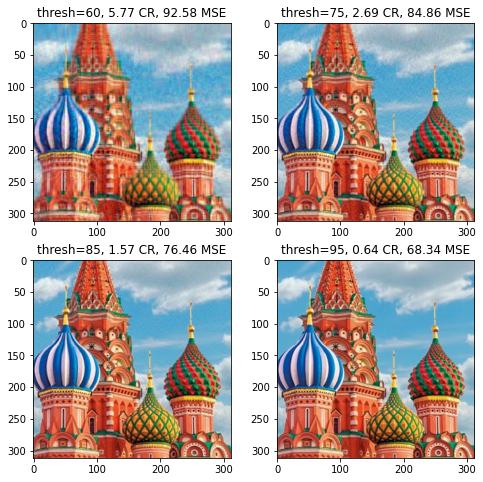

In [8]:
print('Effect of change in threshold value\n')
castle_cm_1, castle_cr_1, castle_mse_1 = compressImage(castle,60)
castle_cm_2, castle_cr_2, castle_mse_2 = compressImage(castle,75)
castle_cm_3, castle_cr_3, castle_mse_3 = compressImage(castle,85)
castle_cm_4, castle_cr_4, castle_mse_4 = compressImage(castle,95)
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.subplot(2,2,1),plt.imshow(castle_cm_1),plt.title('thresh=60, '+str(castle_cr_1)+' CR, '+str(castle_mse_1)+' MSE')
plt.subplot(2,2,2),plt.imshow(castle_cm_2),plt.title('thresh=75, '+str(castle_cr_2)+' CR, '+str(castle_mse_2)+' MSE')
plt.subplot(2,2,3),plt.imshow(castle_cm_3),plt.title('thresh=85, '+str(castle_cr_3)+' CR, '+str(castle_mse_3)+' MSE')
plt.subplot(2,2,4),plt.imshow(castle_cm_4),plt.title('thresh=95, '+str(castle_cr_4)+' CR, '+str(castle_mse_4)+' MSE')

Increasing threshold increases the value of *k* in decomposition.<br>
It is observed (as expected) that with high threshold, MSE decreases as more and more information is retained.<br>
Also, with high threshold, the value of *k* increases and we move more and more towards the original image and hence CR decreases.<br><br>
As a general approach, value of threshold can be kept as 85. It works for most of the cases.<br>

Effect of Block size



(<matplotlib.axes._subplots.AxesSubplot at 0x7fc94538f3c8>,
 Text(0.5, 1.0, 'Block size=4, 155.75 CR, 75.21 MSE'))

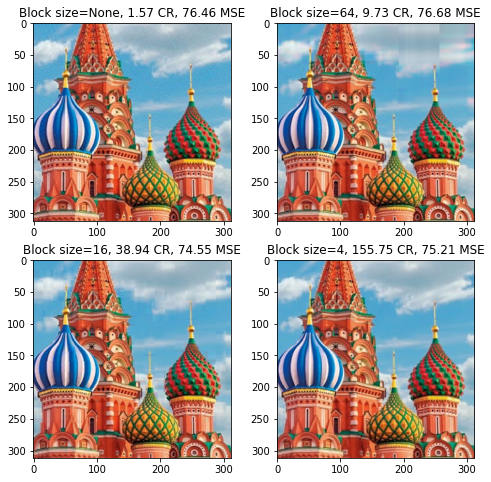

In [9]:
print('Effect of Block size\n')
castle_cm_1, castle_cr_1, castle_mse_1 = compressImage(castle,85,None)
castle_cm_2, castle_cr_2, castle_mse_2 = compressImage(castle,85,64)
castle_cm_3, castle_cr_3, castle_mse_3 = compressImage(castle,85,16)
castle_cm_4, castle_cr_4, castle_mse_4 = compressImage(castle,85,4)
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.subplot(2,2,1),plt.imshow(castle_cm_1),plt.title('Block size=None, '+str(castle_cr_1)+' CR, '+str(castle_mse_1)+' MSE')
plt.subplot(2,2,2),plt.imshow(castle_cm_2),plt.title('Block size=64, '+str(castle_cr_2)+' CR, '+str(castle_mse_2)+' MSE')
plt.subplot(2,2,3),plt.imshow(castle_cm_3),plt.title('Block size=16, '+str(castle_cr_3)+' CR, '+str(castle_mse_3)+' MSE')
plt.subplot(2,2,4),plt.imshow(castle_cm_4),plt.title('Block size=4, '+str(castle_cr_4)+' CR, '+str(castle_mse_4)+' MSE')

It is observed that for a fixed threshold (85), introduction of Block method improves the CR metric without compromising the MSE of image.<br>
This is important because with no block method, the CR was 1.57 while it increases to 39 with block size of 16. This is a significant improvement.<br><br>

#### Example 2 - Cricket Image
Color Image of dimension (5760,4312,3)<br>
- Effects of Block size on Time

In [0]:
cricket = cv2.imread('20200308_185052.jpg')

In [0]:
t0 = datetime.now()
cricket_cm_1, ckt_cr_1, ckt_mse_1 = compressImage(cricket,85)
t1 = datetime.now()
cricket_cm_2, ckt_cr_2, ckt_mse_2 = compressImage(cricket,85,16)
t2 = datetime.now()
cricket_cm_3, ckt_cr_3, ckt_mse_3 = compressImage(cricket,85,64)
t3 = datetime.now()
cricket_cm_4, ckt_cr_4, ckt_mse_4 = compressImage(cricket,85,256)
t4 = datetime.now()

diff_time_1 = int((t1 - t0).total_seconds())
diff_time_2 = int((t2 - t1).total_seconds())
diff_time_3 = int((t3 - t2).total_seconds())
diff_time_4 = int((t4 - t3).total_seconds())

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc942c80160>,
 Text(0.5, 1.0, 'Blocks: 256, Time: 29s'))

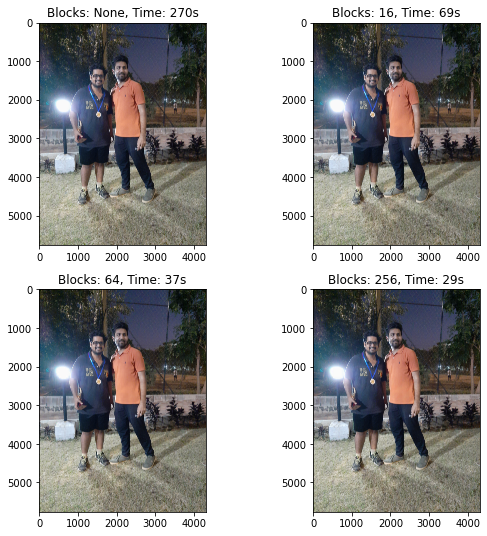

In [44]:
fig = plt.gcf()
fig.set_size_inches(9,9)
plt.subplot(2,2,1),plt.imshow(cricket_cm_1),plt.title('Blocks: None, Time: '+str(diff_time_1)+'s')
plt.subplot(2,2,2),plt.imshow(cricket_cm_2),plt.title('Blocks: 16, Time: '+str(diff_time_2)+'s')
plt.subplot(2,2,3),plt.imshow(cricket_cm_3),plt.title('Blocks: 64, Time: '+str(diff_time_3)+'s')
plt.subplot(2,2,4),plt.imshow(cricket_cm_4),plt.title('Blocks: 256, Time: '+str(diff_time_4)+'s')

For a fixed threhsold (of 85), we very the block size and note the time it takes for compression.<br>
For the compression without Block method, it takes 4.5 minutes while for a block size of 256, it takes 0.5 minute without compromising the CR and MSE (as reported below).<br>
Thus, Block method improves the time it takes for high resolution images to be compressed using SVD technique.<br><br>
Although, this is still expensive and time consuming compared to more modern compression techniques like DCT etc.

In [65]:
print('CR:',ckt_cr_4,', MSE:',ckt_mse_4)

CR: 60.14 , MSE: 67.78
